# Annotating images Using labelMe

In [ ]:
!labelme

# Resize Images if images with different sizes only

In [1]:
import PIL
import os
import os.path
from PIL import Image


path = 'data/originalImages'
for file in os.listdir(path): 
    f_img = path+"/"+file
    img = Image.open(f_img)

    img = img.resize((750, 469)) #(width, height)
    s_path = 'data/images/'+file
    img.save(s_path)

# 2 Building Image Loading Function

### 2.1 Importing TF Dependencies 

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [13]:
images = tf.data.Dataset.list_files('data\\images\\*.jpeg', shuffle=True)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpeg'

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [11]:
images.as_numpy_iterator().next()
# type(images)

NameError: name 'images' is not defined

In [31]:
images_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = images_generator.next()

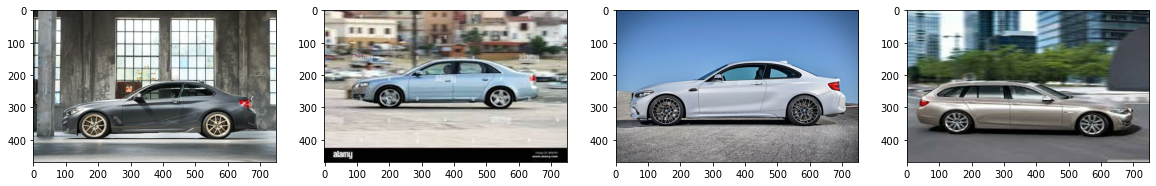

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### divide imageset into train, test and val

##### train = total * 0.7 = 87
##### test = total * 0.15 = 18
##### val = total * 0.15 = 18

### Moving labels to train, test & val folders

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 3. Image Augmentation

In [29]:
import albumentations as alb
import cv2

### 3.1 One image demonstration

In [63]:
augmentor = alb.Compose([alb.RandomCrop(width=460, height=460),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                    bbox_params= alb.BboxParams(format='albumentations',
                        label_fields=['class_labels']))

In [64]:
img = cv2.imread(os.path.join('data','train','images','0a409f4c-e3d0-46b9-b889-9f58d090a051.jpeg'))

In [65]:
with open(os.path.join('data','train','labels','0a409f4c-e3d0-46b9-b889-9f58d090a051.json'), 'r') as f:
    label = json.load(f)

In [66]:
label['shapes']

[{'label': 'side-view',
  'points': [[426.02702702702703, 265.64864864864865],
   [485.4864864864865, 369.7027027027027]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

### 3.2 Extract Coordinates 

In [67]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

coords

[426.02702702702703, 265.64864864864865, 485.4864864864865, 369.7027027027027]

In [68]:
coords = list(np.divide(coords, [750,469,750,469]))

In [69]:
coords

[0.568036036036036, 0.5664150291015962, 0.6473153153153154, 0.8037015276145711]

In [70]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])

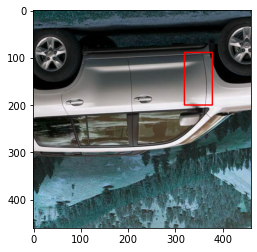

In [74]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2],[460,460]).astype(int)), # top coordinate
                tuple(np.multiply(augmented['bboxes'][0][2:],[460,460]).astype(int)), # bottom coordinate
                (250,0,0),2) # color and thinkness of rectangle 

plt.imshow(augmented['image'])

### 3.3 Transforming all images

In [81]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition, 'images', image ))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [750,469,750,469]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])
                cv2.imwrite(os.path.join('data','aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpeg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('data','aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

### 3.4 Loading Transformed images

In [4]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpeg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x , (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpeg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x , (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpeg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x , (120,120)))
val_images = val_images.map(lambda x: x/255)

## 4. Prepare Labels

In [16]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [17]:
train_labels = tf.data.Dataset.list_files('data\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
test_labels = tf.data.Dataset.list_files('data\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
val_labels = tf.data.Dataset.list_files('data\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 5. Combine Labels with images

#### 5.1 Check partition lenght

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5220, 5220, 1080, 1080, 1080, 1080)

#### 5.2 Final Dataset creation (Images/Labels)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [24]:
train.as_numpy_iterator().next()

(array([[[[0.385512  , 0.41364378, 0.25806102],
          [0.2859477 , 0.30620915, 0.21789216],
          [0.42382896, 0.43807188, 0.39365467],
          ...,
          [0.59117645, 0.70098037, 0.94803923],
          [0.59362745, 0.6997549 , 0.94803923],
          [0.6       , 0.69803923, 0.9490196 ]],
 
         [[0.39370912, 0.43619284, 0.24583334],
          [0.26911765, 0.31446078, 0.14362745],
          [0.32965687, 0.3538399 , 0.24795753],
          ...,
          [0.592647  , 0.69142157, 0.94215685],
          [0.59387255, 0.6911765 , 0.94215685],
          [0.6019608 , 0.6931372 , 0.94509804]],
 
         [[0.24403593, 0.2905228 , 0.10694441],
          [0.3360294 , 0.3848856 , 0.21454246],
          [0.26824617, 0.30383986, 0.13641065],
          ...,
          [0.6006536 , 0.7019608 , 0.9415032 ],
          [0.60400325, 0.6981209 , 0.94125813],
          [0.6081699 , 0.69052285, 0.93758166]],
 
         ...,
 
         [[0.70196074, 0.68627447, 0.77647054],
          [0.70988

### 5.3 Viewing images with annotations

In [25]:
data_samples = train.as_numpy_iterator()

In [31]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


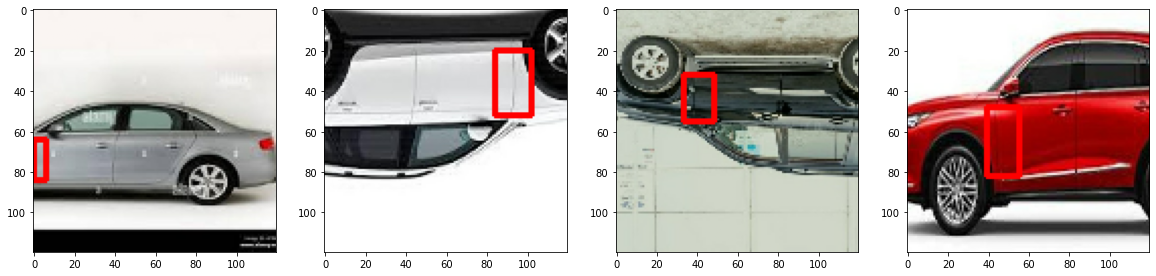

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                (255,0,0), 2)
    ax[idx].imshow(sample_image)

# 6 Deep Learning model

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Add, GlobalMaxPooling2D, Dropout, ReLU
from tensorflow.keras.applications import VGG16

### 6.1 Download VGG16
![alt text](vgg16_img.png "VGG16 Structure")

In [61]:
vgg = VGG16(include_top=False) #download 

In [62]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 6.2 Adding layers to VGG16

In [63]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    ROIExtractor = Model(inputs=input_layer, outputs=[class2, regress2])
    return ROIExtractor

In [64]:
ROIExtractorModel = build_model()

In [65]:
ROIExtractorModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_6[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [66]:
X, y = train.as_numpy_iterator().next()

In [67]:
X

array([[[[0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         ...,
         [0.46241826, 0.55261433, 0.71339864],
         [0.4627451 , 0.5529412 , 0.7137255 ],
         [0.46666667, 0.5568628 , 0.7176471 ]],

        [[0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         ...,
         [0.46241826, 0.55261433, 0.71339864],
         [0.4627451 , 0.5529412 , 0.7137255 ],
         [0.46666667, 0.5568628 , 0.7176471 ]],

        [[0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         [0.42745098, 0.5254902 , 0.68235296],
         ...,
         [0.45912308, 0.54931915, 0.71010345],
         [0.4627451 , 0.5529412 , 0.7137255 ],
         [0.46666667, 0.5568628 , 0.7176471 ]],

        ...,

        [[0.80691737, 0.6657409 , 0.4696625 ],
         [0.8124184 , 0.67124194, 0.48104584]

In [68]:
classes, coords = ROIExtractorModel.predict(X)

1/1 [==============================] - 0s 397ms/step


In [69]:
classes, coords

(array([[0.6031425 ],
        [0.5109485 ],
        [0.5266071 ],
        [0.6165769 ],
        [0.6809074 ],
        [0.62556565],
        [0.6183682 ],
        [0.48627937]], dtype=float32),
 array([[0.5628384 , 0.24976979, 0.3791987 , 0.50280213],
        [0.512283  , 0.23704658, 0.32680133, 0.5838104 ],
        [0.4606596 , 0.25856632, 0.35601345, 0.6175878 ],
        [0.53248197, 0.22516038, 0.41759887, 0.6166383 ],
        [0.48468634, 0.33306327, 0.45313478, 0.58312124],
        [0.53795   , 0.31910235, 0.3989238 , 0.5851843 ],
        [0.40351573, 0.2617971 , 0.41444376, 0.58603185],
        [0.5587559 , 0.31595623, 0.31894577, 0.6349608 ]], dtype=float32))

# 7 Defining Loss Function & Optimizer 

In [70]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [71]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

#### 7.1 Creating Localization Loss and Classification Loss

In [72]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [73]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [74]:
localization_loss(y[1], coords).numpy()

1.5804925

In [75]:
classloss(y[0], classes).numpy()

0.5969509

In [76]:
regressloss(y[1], coords).numpy()

1.5804925

# 8. Train Neural Network

#### 8.1 Creating Custom model class

In [77]:
class ROIExtractor(Model):
    def __init__(self, ROIExtractor, **kwargs):
        super().__init__(**kwargs)
        self.model = ROIExtractor

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt 
    
    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_regressloss}
        
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=True)

        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_regressloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [78]:
model = ROIExtractor(ROIExtractorModel)

In [79]:
model.compile(opt, classloss, regressloss)

#### 8.2 Train

In [80]:
logdir = 'logs'

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train.take(10), epochs=500, validation_data=val, callbacks=[tensorboard_callback])